In [ ]:
%matplotlib inline
from imp import reload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
import os.path
import zipfile
import datetime
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.stats import linregress
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1)
red, blue, green = sns.color_palette("Set1", 3)

plt.warnings.simplefilter("ignore", category=FutureWarning)
plt.warnings.filterwarnings('ignore', message='axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.')

import lmfit
import curveball
from curveball import baranyi_roberts_model 
import os
os.getcwd

In [ ]:
plate = pd.read_csv(r'W-WB-B.csv')
df = curveball.ioutils.read_tecan_xlsx('Dana_WB_150816_edited.xlsx', plate=plate, max_time=14)
df = df[(df.Well != 'C8') & (df.Well != 'C9') & (df.Well != 'C10') & (df.Well != 'A11') & (df.Well != 'A12')]

df1 = df[(df.Row != 'E') & (df.Row != 'F') & (df.Row != 'G') & (df.Row != 'H')]

In [3]:
# in order to get an intiaial parameters guess
m1 = curveball.models.fit_model(df1[df1.Strain=='B'], models=curveball.baranyi_roberts_model.BaranyiRoberts, PLOT=False, PRINT=False)[0]
params_B = m1.best_values
params_B

{'K': 0.33879482144538309,
 'nu': 2.0221991284800236,
 'q0': 0.13066518633729074,
 'r': 0.61272119774896039,
 'v': 0.93041876295170201,
 'y0': 0.18065296422344312}

In [4]:
# in order to get an intiaial parameters guess
m1 = curveball.models.fit_model(df1[df1.Strain=='W'], models=curveball.baranyi_roberts_model.BaranyiRoberts, PLOT=False, PRINT=False)[0]
params_W = m1.best_values
params_W

{'K': 0.32388582772427066,
 'nu': 4.4783735914925167,
 'q0': 0.32901989985966029,
 'r': 0.29744567383348575,
 'v': 0.76695207638118301,
 'y0': 0.18104967438861719}

In [5]:
K, nu, q0, r, v, y0 = params_W['K'], params_W['nu'], params_W['q0'], params_W['r'], params_W['v'], params_W['y0']
lambda_0_W = 1/v * np.log(1 + 1/q0)

K, nu, q0, r, v, y0 = params_B['K'], params_B['nu'], params_B['q0'], params_B['r'], params_B['v'], params_B['y0']
lambda_0_B = 1/v * np.log(1 + 1/q0)

print('lambda_0_W =', lambda_0_W)
print('lambda_0_B =', lambda_0_B)

lambda_0_W = 1.82029469679
lambda_0_B = 2.31930315994


In [6]:
t = np.linspace(0,17)

In [7]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

In [8]:
def s(y_competition):
    rel_fit = (np.log(y_comp[0][0][0]) - np.log(y_comp[-1][0][0]))/(np.log(y_comp[0][1][0]) - np.log(y_comp[-1][1][0]))
    return (rel_fit-1)

In [9]:
# reference strain (W)

K, nu, q0, r, v, y0 = params_W['K'], params_W['nu'], params_W['q0'], params_W['r'], params_W['v'], params_W['y0']
lambda_0 = 1/v * np.log(1 + 1/q0)

xs = np.linspace(0, lambda_0_W, 30)
lags_W = np.empty_like(xs)
ms_W = []
#stds_W = np.empty_like(xs)

for i, x in enumerate(xs):
    lags_per_e = np.empty_like(xs)
    for e in range(0, 30):
        simulated = curveball.baranyi_roberts_model.baranyi_roberts_function(t, y0, K, r, nu, q0, v) +  np.random.normal(loc=0, scale=0.01, size=t.shape)
        simulated[simulated < 0] = 0   
        df = pd.DataFrame({'Time':t, 'OD':simulated})
        m_W = curveball.models.fit_model(df, models=curveball.baranyi_roberts_model.BaranyiRoberts, PLOT=False, PRINT=False)[0]
        params = m_W.best_values
        q0_sim, v_sim = params['q0'], params['v']
        lags_per_e[e] = 1/v_sim * np.log(1 + 1/q0_sim)
        
    lags_per_e = reject_outliers(lags_per_e)
    lags_W[i] = np.mean(lags_per_e)
    ms_W.append(m_W)

In [11]:
print(lambda_0_B)
print(np.mean(lags_W))
print(lags_W)
print(lags_W[1])

2.31930315994
1.68729831073
[ 1.7305922   2.08596735  1.70213713  1.19522922  3.34666291  1.77330653
  1.69173933  2.07773205  1.43974597  1.8490796   1.83961127  1.11579551
  1.43477353  1.26779805  2.2231917   1.41246193  1.48565396  1.54321595
  1.78444347  1.38791872  2.0563136   1.57586573  1.42209202  1.40062337
  3.12634913  1.72981398  1.43812232  1.06610657  1.25288494  1.16372129]
2.08596734992


In [12]:
# assay strain (B)

K, nu, q0, r, v, y0 = params_B['K'], params_B['nu'], params_B['q0'], params_B['r'], params_B['v'], params_B['y0']
lambda_0 = 1/v * np.log(1 + 1/q0)

xs = np.linspace(0, lambda_0_B, 30)
lags_B = np.empty_like(xs)
delta_lags_B = np.empty_like(xs)
s_cs = np.empty_like(xs)
ms_B = []
#stds_B = np.empty_like(xs)

for i, x in enumerate(xs):
    lags_per_e = np.empty_like(xs)
    s_c_per_e = np.empty_like(xs)
    for e in range(0, 30):
        K, nu, q0, r, v, y0 = params_B['K'], params_B['nu'], params_B['q0'], params_B['r'], params_B['v'], params_B['y0']
        simulated = curveball.baranyi_roberts_model.baranyi_roberts_function(t, y0, K, r, nu, q0, v) +  np.random.normal(loc=0, scale=0.01, size=t.shape)
        simulated[simulated < 0] = 0   
        df = pd.DataFrame({'Time':t, 'OD':simulated})
        m_B = curveball.models.fit_model(df, models=curveball.baranyi_roberts_model.BaranyiRoberts, PLOT=False, PRINT=False)[0]
        params = m_B.best_values
        K, nu, q0, r, v, y0 = params['K'], params['nu'], params['q0']*np.exp(params['v']*x), params['r'], params['v'], params['y0']
        lags_per_e[e] = 1/v * np.log(1 + 1/q0)
                
        # in order to update m_B
        simulated = curveball.baranyi_roberts_model.baranyi_roberts_function(t, y0, K, r, nu, q0, v)   
        simulated[simulated < 0] = 0 
        df = pd.DataFrame({'Time':t, 'OD':simulated})
        m_B = curveball.models.fit_model(df, models=curveball.baranyi_roberts_model.BaranyiRoberts, PLOT=False, PRINT=False)[0]
        t_comp, y_comp = curveball.competitions.compete(m_B, ms_W[1])
        s_c_per_e[e] = s(y_comp)
    
    lags_per_e = reject_outliers(lags_per_e)
    lags_B[i] = np.mean(lags_per_e)
#    delta_lags_B[i] = lambda_0_B - lags_B[i]
#    delta_lags_B[i] = np.mean(lags_W) - lags_B[i]
    delta_lags_B[i] = lags_W[1] - lags_B[i]
    
    s_c_per_e = reject_outliers(s_c_per_e)
    s_cs[i] = np.mean(s_c_per_e)
    
    ms_B.append(m_B)
        
#    stds_B[i] = np.std()


In [13]:
W_White = 1
relative_fitness = 1+s_cs 

In [21]:
print('λ:', curveball.baranyi_roberts_model.lag(ms_W[1]))
print('λ:', curveball.baranyi_roberts_model.lag(ms_B[0]))

λ: 8.08282022409
λ: 3.9912782882


In [15]:
# make sense?
#s_cs[s_cs<0] = 0
print('scs:', s_cs)

print('relative fitness(White):', relative_fitness)

#delta_lags_A[delta_lags_A<0] = 0

print(delta_lags_B)

scs: [-0.17849064 -0.17670462 -0.14285606 -0.08302599 -0.05317165 -0.0131003
 -0.07139998  0.03314317  0.03176814  0.09040801  0.08543129  0.13255435
  0.17939771  0.19235701  0.19792129  0.25581     0.22735467  0.27661823
  0.40509567  0.22265476  0.429342    0.34967039  0.42438293  0.36833052
  0.38608653  0.38006889  0.55446235  0.4261378   0.41174516  0.42340366]
relative fitness(White): [ 0.82150936  0.82329538  0.85714394  0.91697401  0.94682835  0.9868997
  0.92860002  1.03314317  1.03176814  1.09040801  1.08543129  1.13255435
  1.17939771  1.19235701  1.19792129  1.25581     1.22735467  1.27661823
  1.40509567  1.22265476  1.429342    1.34967039  1.42438293  1.36833052
  1.38608653  1.38006889  1.55446235  1.4261378   1.41174516  1.42340366]
[ 0.04924164  0.6943539   0.45416164  0.41400949  0.83821364  0.67591226
  1.20729105  0.80797616  1.01614228  1.21581707  0.96468879  0.62959181
  0.62014253  1.25396253  1.34775865  1.33389175  1.08574865  1.39985641
  1.28913227  1.45230

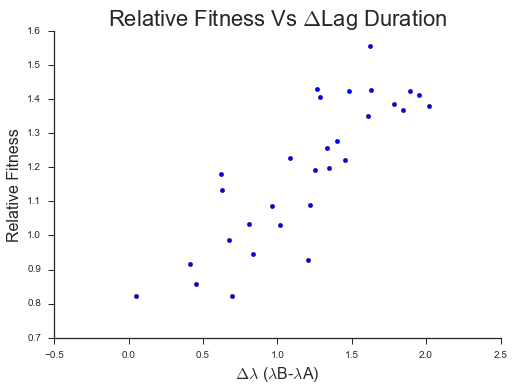

In [16]:
plt.scatter(delta_lags_B, relative_fitness)

plt.title(r'Relative Fitness Vs $\Delta$Lag Duration', size=22)
plt.xlabel(r'$\Delta$$\lambda$ ($\lambda$B-$\lambda$A)', size=16)
plt.ylabel('Relative Fitness', size=16)

sns.despine()

#plt.savefig('Relative Fitness Vs delta_Lag Duration.png')

P-value is 6.5305279233e-09
R^2 is 0.705338546993


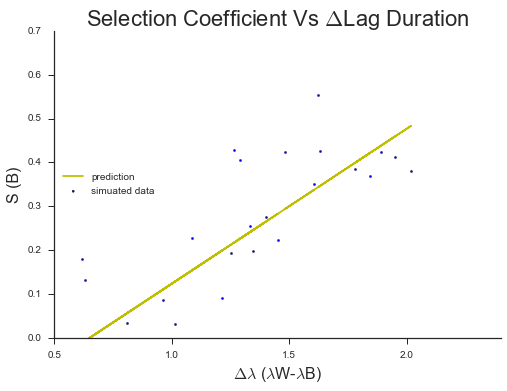

In [26]:
slope, intercept, r_value, p_value, std_err = linregress(delta_lags_B, s_cs)
selection_coefficient = (intercept + slope * delta_lags_B)
print("P-value is", p_value)
print("R^2 is", (r_value)**2)
      
plt.plot(delta_lags_B, selection_coefficient, 'y') # prediction
plt.scatter(delta_lags_B, s_cs, marker='.') # simulated data
#plt.errorbar(delta_lags_A[8:], selection_coefficient, std_err, color='y') # prediction

plt.title(r'Selection Coefficient Vs $\Delta$Lag Duration', size=22)
plt.xlabel(r'$\Delta$$\lambda$ ($\lambda$W-$\lambda$B)', size=16)
plt.ylabel('S (B)', size=16)
plt.legend(['prediction', 'simuated data'], loc='center left')

plt.xlim(0.5,2.4)
plt.ylim(0,0.7)
sns.despine()

#plt.savefig('S Vs delta_Lag - Prediction2b.png')

In [ ]:
#ini_s = selection_coefficient[0]
#print(ini_s)
#f = slope*1 + intercept
#print('s for 1h:',f-ini_s)

In [19]:
#ini_s = selection_coefficient[0]
ini_s = slope*0 + intercept
print(ini_s)
f = slope*1 + intercept
print('s for 1h:',f-ini_s)

-0.230215381379
s for 1h: 0.353505015351


In [ ]:
print(std_err) # represents the average distance that the observed values fall from the regression line. it tells you how wrong the regression model is on average using the units of the response variable.

In [ ]:
#t = (0.5-0.65)/(std_err/np.sqrt(30))
z = (0.6577-0.6568)/(std_err)
print('z:', z)
pv = 0.0136  # change according t table
print('pv:', 2*pv)

Relative Fitness: 0.82422252447


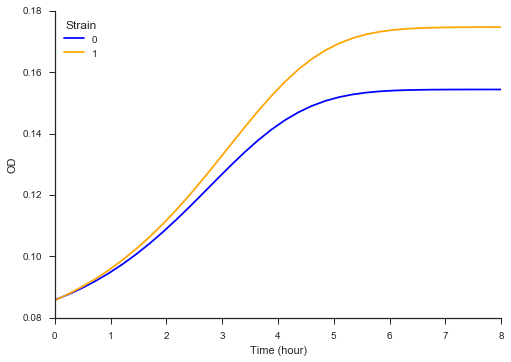

In [22]:
t_comp, y_comp, fig, ax = curveball.competitions.compete(ms_B[0], ms_W[1], PLOT=True, colors=['blue', 'orange'])
plt.xlim(0,8)

select_coeff = s (y_comp)
print('Relative Fitness:',1+select_coeff)